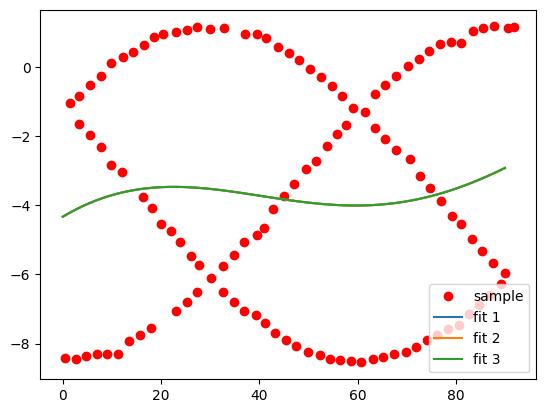

In [3]:
import numpy as np
from scipy.optimize import least_squares
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルの読み込み
csv_file_path = 'xy.csv'
data = pd.read_csv(csv_file_path)

# xとyのデータを抽出
x_data = data.iloc[:, 0].values  # CSVファイルの1列目をxとして使用
y_data = data.iloc[:, 1].values  # CSVファイルの2列目をyとして使用

# 原子を回転させるための行列
def rotation_matrix():
    identity_matrix = np.identity(3)
    matrices = []
    for i in range(3):
        kx = 0
        ky = 0
        kz = 1
        R = np.array([[0, -kz, ky], [kz, 0, -kx], [-ky, kx, 0]])
        t = 120
        theta = np.radians(t * i)
        rot_mat = identity_matrix + np.sin(theta) * R + (1 - np.cos(theta)) * np.dot(R, R)
        matrices.append(rot_mat)
    return matrices

# Rに書き換えてる
R = rotation_matrix()

# ロドリゲスの回転公式×磁場ベクトル
def rodrigues_rotation(n, s, theta):
    n = n[:, np.newaxis]
    s = s[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    h = (s * cos_theta + np.cross(n, s, axis=0) * sin_theta + n * np.dot(n.T, s) * (1 - cos_theta))
    return h

# モデル関数
def model(params, x_data):
    K_rot_values = []
    n = np.array([params[0], params[1], params[2]])
    s = np.array([params[3], params[4], params[5]])
    XX = params[6]
    XY = params[7]
    YY = params[8]
    YZ = params[9]
    XZ = params[10]
    ZZ = params[11]
    K = np.array([[XX, XY, XZ], [XY, YY, YZ], [XZ, YZ, ZZ]])
    
    theta = np.radians(x_data)
    h_vec = rodrigues_rotation(n, s, theta)
    
    for i in range(3):
        R_i = R[i]
        K_rot_i = np.array([np.dot(h_vec[:, j].T, np.dot(R_i, np.dot(K, np.dot(np.linalg.inv(R_i), h_vec[:, j])))) * 1e4 for j in range(len(theta))])
        K_rot_values.append(K_rot_i)
    
    return K_rot_values

def residual(params, x_data, y_data):
    K_rot_values = model(params, x_data)
    residuals = []
    for K_rot in K_rot_values:
        residuals.extend(K_rot - y_data)
    return residuals

plt.plot(x_data, y_data, 'ro', ls='', label='sample')

# ユーザーからパラメータを入力させる関数
par = []
for param in ['n1', 'n2', 'n3', 's1', 's2', 's3', 'K_{xx}', 'K_{xy}', 'K_{yy}', 'K_{yz}', 'K_{xz}', 'K_{zz}']:
    value = float(input(f"Enter value for {param}: "))
    par.append(value)

res = least_squares(residual, par, args=(x_data, y_data))

x_data_fit = np.linspace(0, 90, 100)
K_rot_fit_values = model(res.x, x_data_fit)

for i in range(3):
    plt.plot(x_data_fit, K_rot_fit_values[i], label=f'fit {i+1}')

plt.legend()
plt.show()